# Problem Set 3, due May 2 at 11:59am (i.e., noon).

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

*Also note:* For this assignment we are requiring you to use base **matplotlib** - not Seaborn or other packages. This will help you become familiar with techniques for maintaining fine-grained control over your data visualizations. It will also help our graders, who spent countless hours trying to make various versions import for grading.

In [95]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt 

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [96]:
from sklearn.datasets import load_boston
bdata = load_boston()

In [97]:
bdata.feature_names = np.append(bdata.feature_names, 'MEDV')
boston = pd.DataFrame(bdata.data)
boston['MEDV'] = bdata.target
boston.columns = bdata.feature_names[:]

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

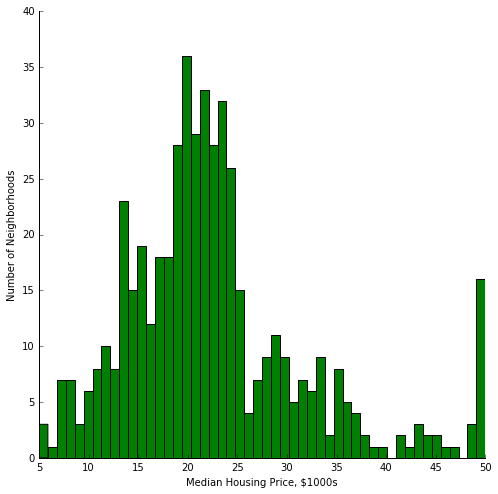

In [98]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

# edit the code below to make the graph look good
fig, ax1 = plt.subplots(figsize=(8,8))
ax1.hist(bdata.target, bins=50, color='green')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
plt.xlabel('Median Housing Price, $1000s')
plt.ylabel('Number of Neighborhoods')

### 1.1: Scatter plot of housing prices and crime

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional. No excuses if you don't get it right this time around!


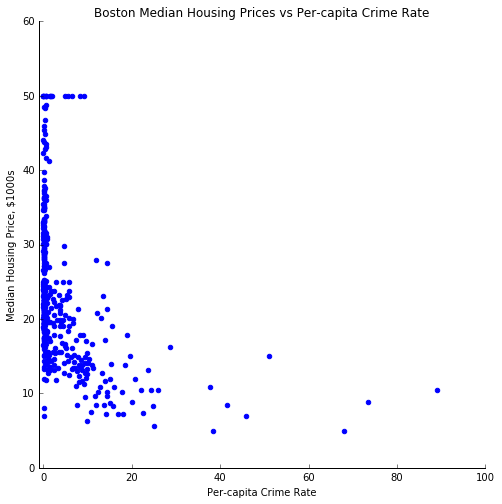

In [99]:
fig, ax = plt.subplots(figsize=(8,8))
y = bdata.target
x = boston['CRIM']
ax.scatter(x, y, color='blue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(xmin=-1)
plt.ylabel('Median Housing Price, $1000s')
plt.xlabel('Per-capita Crime Rate')
plt.title('Boston Median Housing Prices vs Per-capita Crime Rate')
plt.show()

### 1.2 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation)



In [100]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int (float?)
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6))
2.0817
"""
def compute_rmse(predictions, yvalues):
    rmse = 0.0
    for pre, yval in zip(predictions, yvalues):
        rmse += (pre - yval) ** 2
    rmse /= len(predictions)
    return (rmse ** 0.5)

### 1.3 Divide your data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 34% in a testing dataset (call this "bdata_test")


In [34]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

# enter your code here
from sklearn.cross_validation import train_test_split
bdata_train, bdata_test = train_test_split(boston, test_size=0.34)

### 1.4 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set.  Now compute the RMSE on the test data set (but use the model you trained on the training set!).  How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

In [35]:
train = np.empty(len(bdata_train))
train.fill(bdata_train['MEDV'].mean())

In [36]:
print compute_rmse(bdata_train['MEDV'], train) # train

9.43068967879


In [37]:
print compute_rmse(bdata_test['MEDV'], train[0: len(bdata_test)])   # test

8.74957418914


OBSERVATIONS

The RMSE values for the training and testing datasets are relatively close. I would have expected that the training set have a lower RMSE value because we "trained" against the training set data. But this model is not a very good one and the training set probably had more outliers, since it's a larger dataset, than the testing dataset. Means often overreact to outliers which could have raised/lowered the mean by large amounts and this could be the reason why the training dataset had a higher RMSE value than the testing dataset.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm](http://en.wikipedia.org/wiki/Norm_(mathematics) distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).

In [14]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int (float?)
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    dist = 0.0
    for val1, val2 in zip(x1, x2):
        dist += abs(val1 - val2) ** L
    return dist ** (1.0 / L)

### 2.2 Basic Nearest Neighbor algorithm

Now things get fun.  Your task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

In [15]:
"""
Function
--------
nneighbor

Given training and test data sets and a value for L, 
calculate the nearest neighbor value for the test set and return the root mean squared error of the output features
given input features

Parameters
----------
trainSet, testSet : array
    Array of numerical values of the data set

inputFeat : array
    Array of input feature(s)
    
outputFeat : array
    Array of output feature(s)

L: int
    Value of L to use in computing distances

Returns
-------
rmse : float
    The root mean squared error of the predictions of the nearest neighbors

Example
-------
>>> nneighbor(bdata_train, bdata_test, ['CRIM', 'RM'], ['MEDV'], 2)
Time taken: 0.19 seconds
6.6810100998095514

"""
import time
def nneighbor(trainSet, testSet, inputFeat, outputFeat, L):
    start_time = time.time()
    neighbors = []
    for in1, in2 in zip(testSet[inputFeat[0]], testSet[inputFeat[1]]):
        nearest = -1
        for in11, in22, out1 in zip(trainSet[inputFeat[0]], trainSet[inputFeat[1]], trainSet[outputFeat[0]]):
            dist = distance([in1, in2], [in11, in22], L)
            if nearest == -1 or dist < nearest:
                nearest = dist
                value = out1
        neighbors.append(value)
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return compute_rmse(neighbors, testSet[outputFeat[0]])

In [16]:
nneighbor(bdata_train, bdata_test, ['CRIM', 'RM'], ['MEDV'], 2)

Time taken: 0.23 seconds


6.6810100998095514

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [79]:
"""
Function
--------
normalize

Given a dataset (array), return the normalized array
To normalize is to subtract the mean and divide by the standard deviation

Parameters
----------
raw_data : array
    Array of numerical values of the data set

Returns
-------
normalized_data : array
    The normalized array of the raw data

Example
-------
>>> normalize([23,5,1,46,8,8])
return array([ 0.50939719, -0.66113252, -0.92125023,  2.00507403, -0.46604423, -0.46604423])
"""
def normalize(raw_data):
    normalized_data = raw_data
    normalized_data = (raw_data - np.mean(raw_data)) / (1.0 * np.std(raw_data))
    return normalized_data

In [80]:
raw_data = [23,5,1,46,8,8]
normalize(raw_data)

array([ 0.50939719, -0.66113252, -0.92125023,  2.00507403, -0.46604423,
       -0.46604423])

In [81]:
## Normalizing both input/output
print nneighbor(normalize(bdata_train), normalize(bdata_test), ['CRIM', 'RM'], ['MEDV'], 2)

Time taken: 0.18 seconds
0.748313632338


In [60]:
## Normalizing only inputs
import time
def nntest(trainSet, testSet, inputFeat, outputFeat, L):
    start_time = time.time()
    neighbors = []
    for in1, in2 in zip(normalize(testSet[inputFeat[0]]), normalize(testSet[inputFeat[1]])):
        nearest = -1
        for in11, in22, out1 in zip(normalize(trainSet[inputFeat[0]]), normalize(trainSet[inputFeat[1]]), trainSet[outputFeat[0]]):
            dist = distance([in1, in2], [in11, in22], L)
            if nearest == -1 or dist < nearest:
                nearest = dist
                value = out1
        neighbors.append(value)
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return compute_rmse(neighbors, testSet[outputFeat[0]])

In [61]:
## Normalizing only inputs
print nntest(bdata_train, bdata_test, ['CRIM', 'RM'], ['MEDV'], 2)

Time taken: 0.34 seconds
6.80097323875


OBSERVATION

Originally I normalized everything including the output, MEDV. After only normalizing the input, we find that the RMSE increased by about 0.12. I expected it to decrease because normalizing would make the inputs more "accurate". However this was not the case.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

In [69]:
print nneighbor(bdata_train, bdata_test, ['PTRATIO', 'RM'], ['MEDV'], 2)

Time taken: 0.2 seconds
5.77746269088


In [23]:
import time
def nn4(trainSet, testSet, L):
    start_time = time.time()
    neighbors = []
    for in1, in2, in3, in4 in zip(testSet['ZN'], testSet['INDUS'], testSet['AGE'], testSet['TAX']):
        nearest = -1
        for in11, in22, in33, in44, out1 in zip(trainSet['ZN'], trainSet['INDUS'], trainSet['AGE'], trainSet['TAX'], trainSet['MEDV']):
            dist = distance([in1, in2, in3, in4], [in11, in22, in33, in44], L)
            if nearest == -1 or dist < nearest:
                nearest = dist
                value = out1
        neighbors.append(value)
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return compute_rmse(neighbors, testSet['MEDV'])

In [74]:
print nn4(bdata_train, bdata_test, 2)

Time taken: 0.25 seconds
8.41076587826


In [77]:
print nn4(bdata_train, bdata_test, 10000)

Time taken: 0.32 seconds
8.51219798001


OBSERVATIONS

I'm not sure if it is the lowest RMSE, but using PTRATIO and RM as the two input features results in a RMSE value of 0.601. In general, the more features we add the longer time it will take for the algorithim to run. This makes sense because essentially more calculations need to be processed. Also, increasing the value of L to high numbers increases the run time, but not by much. This is attributed to much larger numbers being calculated. I find it interesting that increasing the L value isn't correlated with the RMSE value (at least not for the four features I tested). Increasing the L value to 10, 100, 1000, or even 10000 gave varying directions of the change in RMSE value.

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see K-fold [cross-validation](http://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [56]:
"""
Function
--------
kFoldCV

Cross-Validation

Parameters
----------
dataSet : array/dataFrame
    The data

inputFeat : array
    Array of input feature(s)
    
outputFeat : array
    Array of output feature(s)

L: int
    Value of L to use in computing distances

k: int
    Number of partitions

Returns
-------
rmse : float
    The root mean squared error of the predictions of the nearest neighbors

Example
-------
>>> kFoldCV(boston, ['CRIM', 'RM'], ['MEDV'], 2, 10)
Time taken: 7.31 seconds
10.6348940417

"""
import time
from sklearn.cross_validation import ShuffleSplit
def kFoldCV(dataSet, inputFeat, outputFeat, L, k):
    start_time = time.time()
    cumRMSE = 0
    # splits dataset's indexes into k partitions
    randomSplit = ShuffleSplit(len(dataSet), n_iter=k, test_size=(1.0 / k), random_state=0)
    for trainIndex, testIndex in randomSplit:
        neighbors = []
        for index in testIndex:
            in1 = dataSet[inputFeat[0]][index]
            in2 = dataSet[inputFeat[1]][index]
            nearest = -1
            for indexTR in trainIndex:
                in11 = dataSet[inputFeat[0]][indexTR]
                in22 = dataSet[inputFeat[1]][indexTR]
                out1 = dataSet[outputFeat[0]][indexTR]
                dist = distance([in1, in2], [in11, in22], L)
                if nearest == -1 or dist < nearest:
                    nearest = dist
                    value = out1
            neighbors.append(value)
        cumRMSE += compute_rmse(neighbors, dataSet[outputFeat[0]])
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return (cumRMSE / (1.0 * k))

In [57]:
print kFoldCV(boston, ['CRIM', 'RM'], ['MEDV'], 2, 10)

Time taken: 6.81 seconds
10.6348940417


### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [72]:
"""
Function
--------
kFoldCV

Cross-Validation

Parameters
----------
dataSet : array/dataFrame
    The data

inputFeat : array
    Array of input feature(s)
    
outputFeat : array
    Array of output feature(s)

L: int
    Value of L to use in computing distances
    
k: int
    Number of partitions

K: int
    Number of neighbors

Returns
-------
rmse : float
    The root mean squared error of the predictions of the nearest neighbors

Example
-------
>>> knn(boston, ['CRIM', 'RM'], ['MEDV'], 2, 10, 3)
Time taken: 6.91 seconds
7.41564981869

"""
import time
from sklearn.cross_validation import ShuffleSplit
def knn(dataSet, inputFeat, outputFeat, L, k, K):
    start_time = time.time()
    cumRMSE = 0
    # splits dataset's indexes into k partitions
    randomSplit = ShuffleSplit(len(dataSet), n_iter=k, test_size=(1.0 / k), random_state=0)
    for trainIndex, testIndex in randomSplit:
        neighbors = []
        for index in testIndex:
            in1 = dataSet[inputFeat[0]][index]
            in2 = dataSet[inputFeat[1]][index]
            near = [] # K nearest distances
            KN = [] # K nearest values
            farthest = -1
            for indexTR in trainIndex:
                in11 = dataSet[inputFeat[0]][indexTR]
                in22 = dataSet[inputFeat[1]][indexTR]
                out1 = dataSet[outputFeat[0]][indexTR]
                dist = distance([in1, in2], [in11, in22], L)
                if len(KN) < K: # if the list of neighbors is not full add to distance & value lists
                    near.append(dist)
                    KN.append(out1)
                    if dist > farthest:
                        farthest = dist # new farthest distance
                else:
                    if dist < max(near): # is the dist even a worthy neighbor?
                        for index, val in enumerate(near):
                            if dist < farthest and val == farthest: # replace the furthest neighbor
                                    near[index] = dist # replace furthest neighbor
                                    farthset = dist # set furthest neighbor
                                    KN[index] = out1 # set furthest value
                
            neighbors.append(np.mean(KN))
        cumRMSE += compute_rmse(neighbors, dataSet[outputFeat[0]])
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return (cumRMSE / (1.0 * k))

In [78]:
print knn(boston, ['CRIM', 'RM'], ['MEDV'], 2, 10, 3)

Time taken: 6.91 seconds
7.41564981869


### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [83]:
import time
from sklearn.cross_validation import ShuffleSplit
def knnS(dataSet, inputFeat, outputFeat, L, k, K):
    ndataSet = normalize(dataSet)
    start_time = time.time()
    cumRMSE = 0
    # splits dataset's indexes into k partitions
    randomSplit = ShuffleSplit(len(dataSet), n_iter=k, test_size=(1.0 / k), random_state=0)
    for trainIndex, testIndex in randomSplit:
        neighbors = []
        for index in testIndex:
            in1 = ndataSet[inputFeat[0]][index]
            in2 = ndataSet[inputFeat[1]][index]
            in3 = ndataSet[inputFeat[2]][index]
            in4 = ndataSet[inputFeat[3]][index]
            in5 = ndataSet[inputFeat[4]][index]
            in6 = ndataSet[inputFeat[5]][index]
            near = [] # K nearest distances
            KN = [] # K nearest values
            farthest = -1
            for indexTR in trainIndex:
                in11 = ndataSet[inputFeat[0]][indexTR]
                in22 = ndataSet[inputFeat[1]][indexTR]
                in33 = ndataSet[inputFeat[2]][indexTR]
                in44 = ndataSet[inputFeat[3]][indexTR]
                in55 = ndataSet[inputFeat[4]][indexTR]
                in66 = ndataSet[inputFeat[5]][indexTR]
                out1 = dataSet[outputFeat[0]][indexTR]
                dist = distance([in1, in2, in3, in4, in5, in6], [in11, in22, in33, in44, in55, in66], L)
                if len(KN) < K: # if the list of neighbors is not full add to distance & value lists
                    near.append(dist)
                    KN.append(out1)
                    if dist > farthest:
                        farthest = dist # new farthest distance
                else:
                    if dist < max(near): # is the dist even a worthy neighbor?
                        for index, val in enumerate(near):
                            if dist < farthest and val == farthest: # replace the furthest neighbor
                                    near[index] = dist # replace furthest neighbor
                                    farthset = dist # set furthest neighbor
                                    KN[index] = out1 # set furthest value
                
            neighbors.append(np.mean(KN))
        cumRMSE += compute_rmse(neighbors, dataSet[outputFeat[0]])
    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return (cumRMSE / (1.0 * k))

In [92]:
kVals = []
for i in range(1, 26):
    kVals.append(knnS(boston, ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], ['MEDV'], 2, 10, i))
print kVals

Time taken: 15.58 seconds
Time taken: 14.93 seconds
Time taken: 15.19 seconds
Time taken: 15.9 seconds
Time taken: 16.17 seconds
Time taken: 16.73 seconds
Time taken: 17.5 seconds
Time taken: 16.83 seconds
Time taken: 15.97 seconds
Time taken: 15.65 seconds
Time taken: 15.87 seconds
Time taken: 16.12 seconds
Time taken: 15.61 seconds
Time taken: 15.65 seconds
Time taken: 15.65 seconds
Time taken: 15.63 seconds
Time taken: 15.75 seconds
Time taken: 15.79 seconds
Time taken: 17.02 seconds
Time taken: 18.28 seconds
Time taken: 15.96 seconds
Time taken: 15.91 seconds
Time taken: 15.82 seconds
Time taken: 16.03 seconds
Time taken: 16.04 seconds
[8.6123513309831843, 7.4979841421657625, 7.3653769220921745, 7.3418080059787503, 7.2238318607178993, 6.8524283893500257, 6.9315933419767743, 6.8918592783278241, 6.7904120530373522, 6.6318933141776402, 6.5141029447134624, 6.4214021473300589, 6.3994193201542036, 6.3641744348752383, 6.270513622150089, 6.3363853814996558, 6.4088942576578587, 6.3642101974

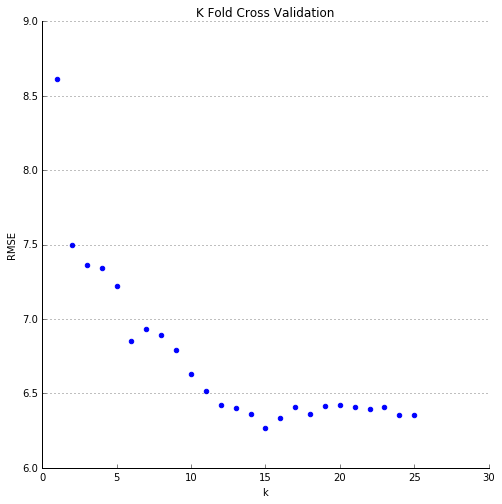

In [94]:
%matplotlib inline
figure, ax = plt.subplots(figsize=(8,8))
y = kVals
x = list(range(1, 26))
ax.scatter(x, y, color='blue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.grid()
ax.set_xlim(xmin=0)
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('K Fold Cross Validation')
plt.show()

IF my scatter plot is accurate, I would choose K=15 as the K value to choose because it resulted in the smallest RMSE.

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*